In [1]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
from datetime import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
df_cards = pd.read_csv('../data/cards_data.csv')
df_users = pd.read_csv('../data/users_data.csv')

# **Data preprocessing**

In [3]:
df_cards.drop(columns=['card_on_dark_web'], inplace=True)

### **current_age since we have birth_year and birth_month to get estimate about age rather than making a new column so we will drop it**

In [4]:
current_year = datetime.now().year
current_month = datetime.now().month
df_users['current_age'] = (current_year - df_users['birth_year']) - (df_users['birth_month'] > current_month).astype(int)

In [5]:
df_cards['credit_limit'] = df_cards['credit_limit'].str.replace(r'[\$,]', '', regex=True).astype(float)
df_users['per_capita_income'] = df_users['per_capita_income'].str.replace(r'[\$,]', '', regex=True).astype(float)
df_users['yearly_income'] = df_users['yearly_income'].str.replace(r'[\$,]', '', regex=True).astype(float)
df_users['total_debt'] = df_users['total_debt'].str.replace(r'[\$,]', '', regex=True).astype(float)

In [6]:
df_cards['acct_open_date'] = pd.to_datetime(df_cards['acct_open_date'], format="%m/%Y", errors='coerce')

In [7]:
# Determine retirement status
df_users['retirement_status'] = np.where(
    df_users['current_age'] >= df_users['retirement_age'],
    'Retired',
    'Not Retired'
)

# **Merging both tables for ease of analysis OLAP**
![ Alt Text](https://media.licdn.com/dms/image/v2/C5612AQGwoAG3_wE70w/article-inline_image-shrink_1000_1488/article-inline_image-shrink_1000_1488/0/1575272101263?e=1745452800&v=beta&t=1VUl32ouX6eRIs6ym3nCtK9196fMsHtNWGaiPxhXiiI)

In [8]:
df_merged = pd.merge(df_users, df_cards, left_on="id", right_on="client_id", how="left")
df_merged.head()

,id_x,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,...,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed
0,825,58,66,1966,11,Female,462 Rose Lane,34.15,-117.76,29278.0,...,Visa,Debit,4344676511950444,12/2022,623,YES,2,24295.0,2002-09-01,2008
1,825,58,66,1966,11,Female,462 Rose Lane,34.15,-117.76,29278.0,...,Visa,Debit,4956965974959986,12/2020,393,YES,2,21968.0,2014-04-01,2014
2,825,58,66,1966,11,Female,462 Rose Lane,34.15,-117.76,29278.0,...,Visa,Debit,4582313478255491,02/2024,719,YES,2,46414.0,2003-07-01,2004
3,825,58,66,1966,11,Female,462 Rose Lane,34.15,-117.76,29278.0,...,Visa,Credit,4879494103069057,08/2024,693,NO,1,12400.0,2003-01-01,2012
4,825,58,66,1966,11,Female,462 Rose Lane,34.15,-117.76,29278.0,...,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,28.0,2008-09-01,2009


In [9]:
# Check for duplicated rows
df_duplicated = df_merged[df_merged.duplicated()]
print(df_duplicated)

Empty DataFrame
Columns: [id_x, current_age, retirement_age, birth_year, birth_month, gender, address, latitude, longitude, per_capita_income, yearly_income, total_debt, credit_score, num_credit_cards, retirement_status, id_y, client_id, card_brand, card_type, card_number, expires, cvv, has_chip, num_cards_issued, credit_limit, acct_open_date, year_pin_last_changed]
Index: []

[0 rows x 27 columns]


In [10]:
# Print schema
df_merged.dtypes

id_x                              int64
current_age                       int64
retirement_age                    int64
birth_year                        int64
birth_month                       int64
gender                           object
address                          object
latitude                        float64
longitude                       float64
per_capita_income               float64
yearly_income                   float64
total_debt                      float64
credit_score                      int64
num_credit_cards                  int64
retirement_status                object
id_y                              int64
client_id                         int64
card_brand                       object
card_type                        object
card_number                       int64
expires                          object
cvv                               int64
has_chip                         object
num_cards_issued                  int64
credit_limit                    float64


In [11]:
df_merged["id_y"].nunique()

6146

In [12]:
df_merged.describe()  # Describe numeric columns

,id_x,current_age,retirement_age,birth_year,birth_month,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,id_y,client_id,card_number,cvv,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed
count,6146.000000,6146.000000,6146.000000,6146.000000,6146.000000,6146.000000,6146.000000,6146.000000,6146.000000,6146.000000,6146.000000,6146.000000,6146.000000,6146.000000,6.146000e+03,6146.000000,6146.000000,6146.000000,6146,6146.000000
mean,994.939636,55.139766,66.544582,1969.050439,6.467296,37.314732,-91.801489,23254.139440,45313.309795,57644.721445,718.252522,3.945005,3072.500000,994.939636,4.820426e+15,506.220794,1.503091,14347.493980,2011-01-15 12:55:31.727953152,2013.436707
min,0.000000,23.000000,50.000000,1918.000000,1.000000,20.880000,-159.410000,0.000000,1.000000,0.000000,480.000000,1.000000,0.000000,0.000000,3.001055e+14,0.000000,1.000000,0.000000,1991-01-01 00:00:00,2002.000000
25%,492.250000,40.000000,65.000000,1957.000000,3.000000,33.820000,-97.510000,16844.000000,32295.000000,16803.000000,687.000000,3.000000,1536.250000,492.250000,4.486365e+15,257.000000,1.000000,7042.750000,2006-10-01 00:00:00,2010.000000
50%,992.000000,55.000000,67.000000,1970.000000,7.000000,38.160000,-86.795000,20646.500000,40251.000000,51529.500000,717.500000,4.000000,3072.500000,992.000000,5.108957e+15,516.500000,1.000000,12592.500000,2010-02-15 00:00:00,2013.000000
75%,1495.000000,68.000000,69.000000,1984.000000,10.000000,41.130000,-80.130000,26369.000000,52531.500000,84494.500000,760.000000,5.000000,4608.750000,1495.000000,5.585237e+15,756.000000,2.000000,19156.500000,2016-05-01 00:00:00,2017.000000
max,1999.000000,106.000000,79.000000,2002.000000,12.000000,61.200000,-68.670000,163145.000000,307018.000000,516263.000000,850.000000,9.000000,6145.000000,1999.000000,6.997197e+15,999.000000,3.000000,151223.000000,2020-02-01 00:00:00,2020.000000
std,578.614626,18.975960,3.455030,18.969825,3.547927,5.148899,16.454556,11512.323216,23314.172216,51633.885249,63.227622,1.668031,1774.341709,578.614626,1.328582e+15,289.431123,0.519191,12014.463884,NaN,4.270699


In [13]:
df_merged.select_dtypes(include=['object']).head()  # Only strings

,gender,address,retirement_status,card_brand,card_type,expires,has_chip
0,Female,462 Rose Lane,Not Retired,Visa,Debit,12/2022,YES
1,Female,462 Rose Lane,Not Retired,Visa,Debit,12/2020,YES
2,Female,462 Rose Lane,Not Retired,Visa,Debit,02/2024,YES
3,Female,462 Rose Lane,Not Retired,Visa,Credit,08/2024,NO
4,Female,462 Rose Lane,Not Retired,Mastercard,Debit (Prepaid),03/2009,YES


# **Analyzing Association Between Categorical Variables**
## Chi-square Statistic
### When dealing with counts and investigating how far the observed counts are from the expected counts, we use a test statistic called the chi-square ($ \chi^2 $) statistic.
$$
X^2 = \chi^2_{\text{stat}} = \sum_{i=1}^{k} \frac{(O_i - E_i)^2}{E_i}
$$

### Squaring the difference between the observed and the expected outcome does two things:
- Any standardized difference that is squared will now be positive.
- Differences that already looked unusual will become much larger after being
squared.

### p-value: (probability value) -- how likely is it that your data would have occurred by random chance if is true

### The p-value for a chi-square test is defined as the tail area above the calculated test statistic.

### Conditions for the Chi-square Test
1. Independence: Each case that contributes a count to the table must be
independent of all the other cases in the table.
2. Sample size: Each particular scenario (i.e. "cell") must have at least 5
expected cases.
3. df ≥ 1: Degrees of freedom must be at least 1.



### Now let's check for association between some categorical variables 

### Determine if gender affects card brand

In [ ]:
# Step 1: Hypotheses
H0 = "Gender and Card Brand are independent. Gender does not affect Card Brand."
HA = "Gender and Card Brand are dependent. Gender affects Card Brand."

print("Null Hypothesis (H0):", H0)
print("Alternative Hypothesis (HA):", HA)

# Step 2: Create Contingency Table Manually
contingency_table = df_merged.groupby(["gender", "card_brand"]).size().reset_index(name="count")

# Reshape the table into a matrix format
contingency_matrix = contingency_table.pivot(index="gender", columns="card_brand", values="count").fillna(0)

print("\nContingency Table:\n", contingency_matrix)

# Step 3: Perform Chi-Squared Test
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_matrix)

# Step 4: Print Results
print("\nChi-Squared Statistic:", chi2_stat)
print("Degrees of Freedom:", dof)
print("P-Value:", p_value)

# Step 5: Conclusion
alpha = 0.05  # Significance Level
if p_value < alpha:
    print("\nSince p-value is low, we reject H0.")
    print("Conclusion: The data provides convincing evidence that Gender and Card Brand are dependent.")
else:
    print("\nSince p-value is high, we fail to reject H0.")
    print("Conclusion: The data does not provide convincing evidence that Gender affects Card Brand.")


Null Hypothesis (H0): Gender and Card Brand are independent. Gender does not affect Card Brand.
Alternative Hypothesis (HA): Gender and Card Brand are dependent. Gender affects Card Brand.

Contingency Table:
 card_brand  Amex  Discover  Mastercard  Visa
gender                                      
Female       221       115        1651  1152
Male         181        94        1558  1174

Chi-Squared Statistic: 6.161289477743501
Degrees of Freedom: 3
P-Value: 0.10402145356948415

Since p-value is high, we fail to reject H0.
Conclusion: The data does not provide convincing evidence that Gender affects Card Brand.


### Determine if gender affects card type

In [23]:
# Step 1: Hypotheses
H0 = "Gender and Card type are independent. Gender does not affect Card type."
HA = "Gender and Card type are dependent. Gender affects Card type."

print("Null Hypothesis (H0):", H0)
print("Alternative Hypothesis (HA):", HA)

# Step 2: Create Contingency Table Manually
contingency_table = df_merged.groupby(["gender", "card_type"]).size().reset_index(name="count")

# Reshape the table into a matrix format
contingency_matrix = contingency_table.pivot(index="gender", columns="card_type", values="count").fillna(0)

print("\nContingency Table:\n", contingency_matrix)

# Step 3: Perform Chi-Squared Test
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_matrix)

# Step 4: Print Results
print("\nChi-Squared Statistic:", chi2_stat)
print("Degrees of Freedom:", dof)
print("P-Value:", p_value)

# Step 5: Conclusion
alpha = 0.05  # Significance Level
if p_value < alpha:
    print("\nSince p-value is low, we reject H0.")
    print("Conclusion: The data provides convincing evidence that Gender and Card type are dependent.")
else:
    print("\nSince p-value is high, we fail to reject H0.")
    print("Conclusion: The data does not provide convincing evidence that Gender affects Card type.")


Null Hypothesis (H0): Gender and Card type are independent. Gender does not affect Card type.
Alternative Hypothesis (HA): Gender and Card type are dependent. Gender affects Card type.

Contingency Table:
 card_type  Credit  Debit  Debit (Prepaid)
gender                                   
Female       1043   1814              282
Male         1014   1697              296

Chi-Squared Statistic: 1.8126588840411342
Degrees of Freedom: 2
P-Value: 0.40400442746042986

Since p-value is high, we fail to reject H0.
Conclusion: The data does not provide convincing evidence that Gender affects Card type.


## **Comparing Several Means: Analysis of Variance**
### Here we analyze the mean of numerical variables across categorical groups

### Comparing Several Means: Analysis of Variance (ANOVA)
- **Objective**: Determine if there are any statistically significant differences between the means of different groups in your dataset.

- **Application**: You can use ANOVA to compare the means of a numerical variable (e.g., yearly_income, credit_score, total_debt) across different categorical groups (e.g., gender, retirement_status, card_brand, card_type).



In [24]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6146 entries, 0 to 6145
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id_x                   6146 non-null   int64         
 1   current_age            6146 non-null   int64         
 2   retirement_age         6146 non-null   int64         
 3   birth_year             6146 non-null   int64         
 4   birth_month            6146 non-null   int64         
 5   gender                 6146 non-null   object        
 6   address                6146 non-null   object        
 7   latitude               6146 non-null   float64       
 8   longitude              6146 non-null   float64       
 9   per_capita_income      6146 non-null   float64       
 10  yearly_income          6146 non-null   float64       
 11  total_debt             6146 non-null   float64       
 12  credit_score           6146 non-null   int64         
 13  num

In [25]:
import seaborn as sns
import scipy.stats as stats
import statsmodels.formula.api as smf
import pingouin as pg
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp


=== Hypotheses for ANOVA ===
Null Hypothesis (H₀): The mean yearly_income is the same for all card_brand groups.
Alternative Hypothesis (H₁): At least one card_brand group has a different mean yearly_income.

=== Checking Assumptions ===
Shapiro-Wilk test for Visa: p-value = 0.000000000
Shapiro-Wilk test for Mastercard: p-value = 0.000000000
Shapiro-Wilk test for Discover: p-value = 0.000000000
Shapiro-Wilk test for Amex: p-value = 0.000000000


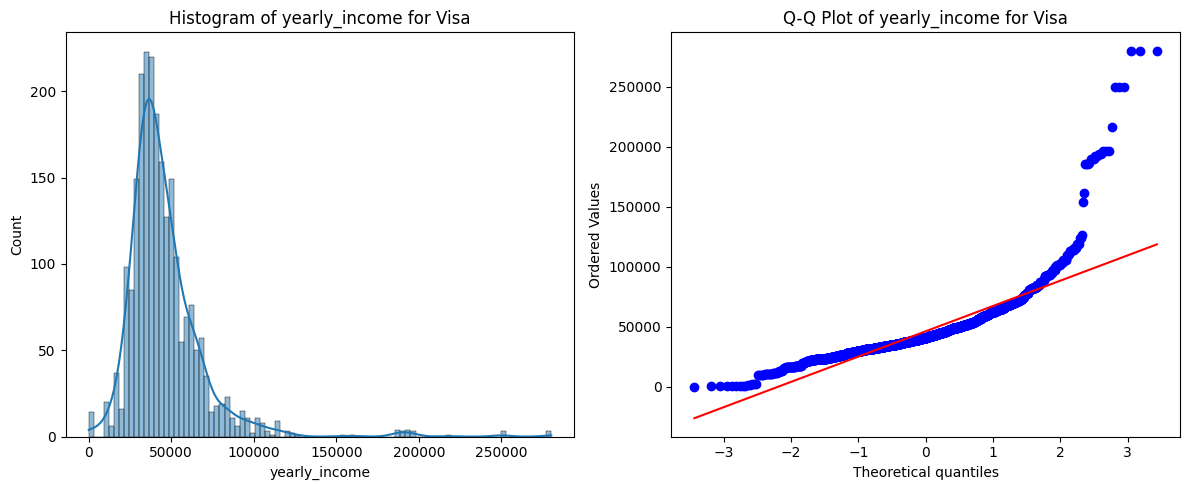

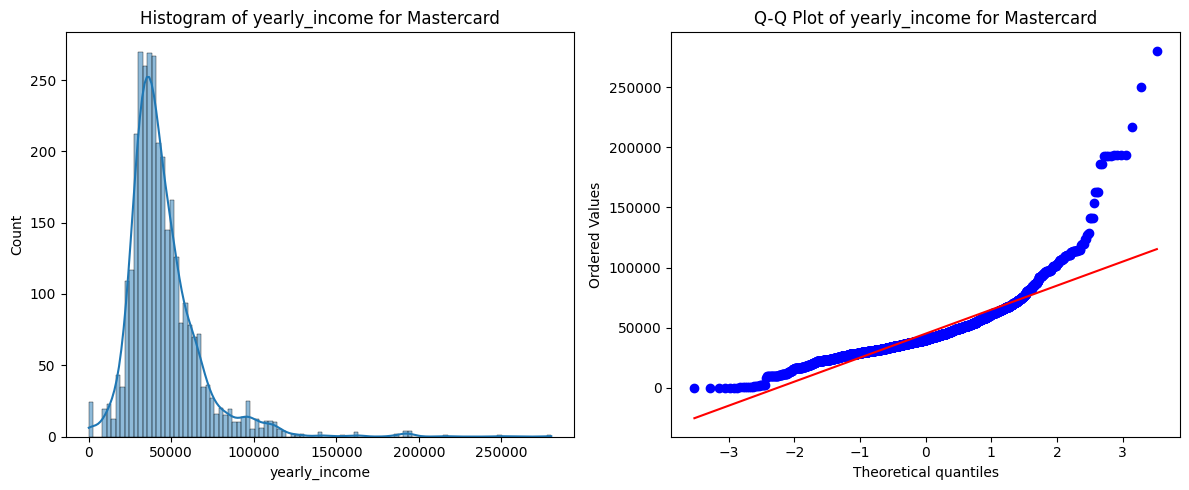

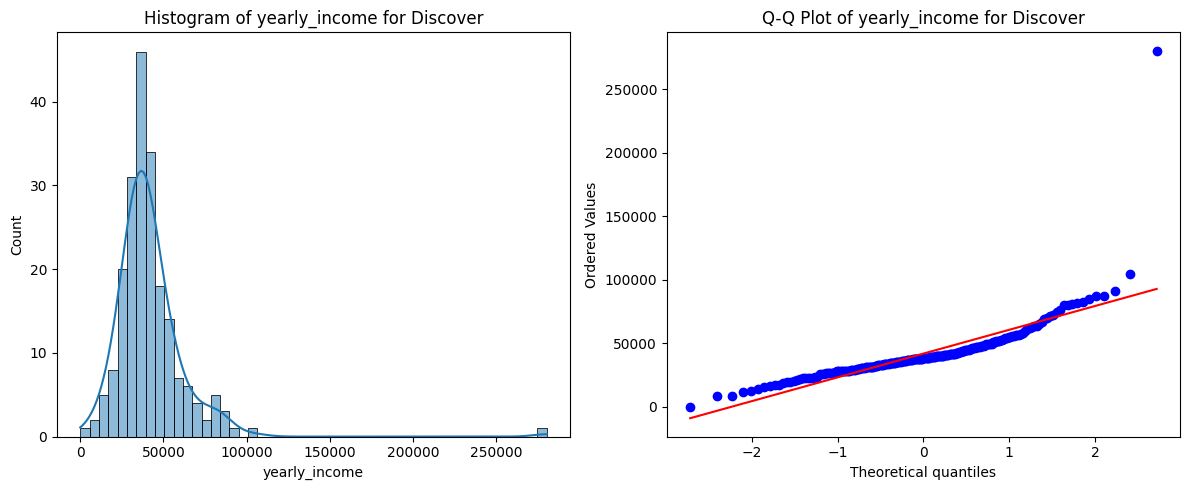

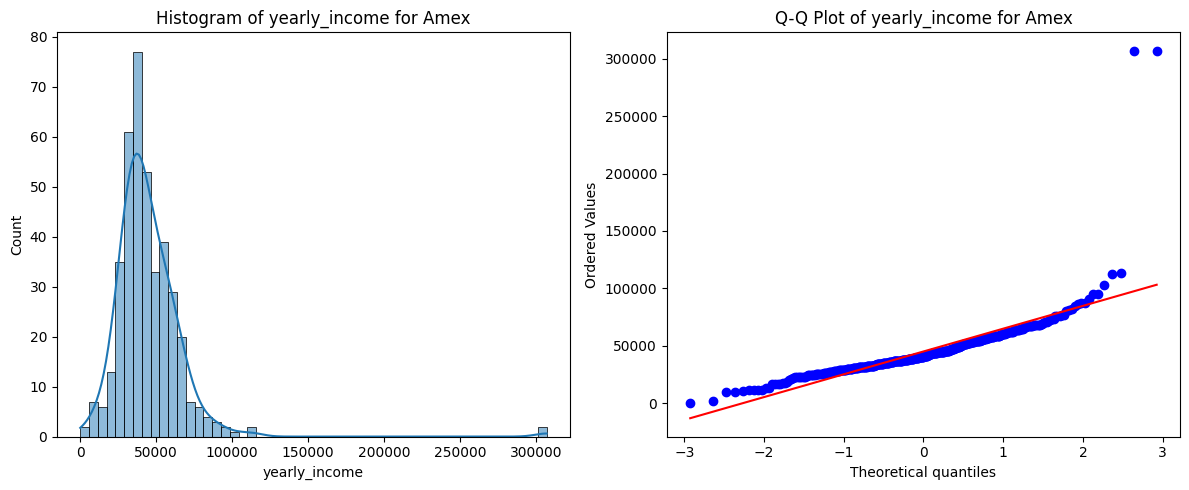


Levene's Test for Equal Variances: p-value = 0.3985

Assumptions for ANOVA are not fully met.
Normality assumption is violated.
Proceeding with the non-parametric Kruskal-Wallis test.

Kruskal-Wallis Test Results:
             Source  ddof1         H     p-unc
Kruskal  card_brand      3  9.202318  0.026718

The p-value is less than 0.05. Reject the null hypothesis.
There is a significant difference in the median yearly_income between card_brand groups.

Dunn's Post-hoc Test Results (with Bonferroni adjustment):
          1         2         3        4
1  1.000000  0.820889  0.023987  1.00000
2  0.820889  1.000000  0.114457  1.00000
3  0.023987  0.114457  1.000000  0.12451
4  1.000000  1.000000  0.124510  1.00000
Significant difference between group 1 and group 3 with p-value: 0.023987
Significant difference between group 3 and group 1 with p-value: 0.023987

=== Analysis Complete ===


In [28]:
# Define the column names for the analysis
numeric_var = 'yearly_income'  # This is the numeric variable (dependent variable)
categorical_var = 'card_brand'    # This is the categorical variable (independent variable)

print("\n=== Hypotheses for ANOVA ===")
print(f"Null Hypothesis (H₀): The mean {numeric_var} is the same for all {categorical_var} groups.")
print(f"Alternative Hypothesis (H₁): At least one {categorical_var} group has a different mean {numeric_var}.")

# -------------------------------------------
# 1. Check Assumptions
# -------------------------------------------
print("\n=== Checking Assumptions ===")
# a. Normality: Using Shapiro-Wilk test for each group
categories = df_merged[categorical_var].unique()
normality_results = {}
for category in categories:
    group_data = df_merged[df_merged[categorical_var] == category][numeric_var].dropna()
    stat, p = stats.shapiro(group_data)
    normality_results[category] = p
    print(f"Shapiro-Wilk test for {category}: p-value = {p:.9f}")

# Plot histograms and Q-Q plots for each group to visually inspect normality
for category in categories:
    group_data = df_merged[df_merged[categorical_var] == category][numeric_var].dropna()
    plt.figure(figsize=(12, 5))
    # Histogram with KDE
    plt.subplot(1, 2, 1)
    sns.histplot(group_data, kde=True)
    plt.title(f"Histogram of {numeric_var} for {category}")

    # Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(group_data, dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of {numeric_var} for {category}")
    plt.tight_layout()
    plt.show()

# b. Equal Variances: Using Levene's test
groups_data = [df_merged[df_merged[categorical_var] == category][numeric_var].dropna() for category in categories]
levene_stat, levene_p = stats.levene(*groups_data)
print(f"\nLevene's Test for Equal Variances: p-value = {levene_p:.4f}")

# Evaluate whether the assumptions are met
normality_met = all(p > 0.05 for p in normality_results.values())
equal_variances_met = levene_p > 0.05

# -------------------------------------------
# 2. Perform ANOVA or Non-Parametric Test
# -------------------------------------------
if normality_met and equal_variances_met:
    print("\nAssumptions met. Proceeding with ANOVA.")
    # Perform one-way ANOVA using pingouin
    aov = pg.anova(data=df_merged, dv=numeric_var, between=categorical_var)
    print("\nANOVA Results:")
    print(aov)
        
    # Check the overall p-value from the ANOVA test
    anova_p = aov['p-unc'].values[0]
    if anova_p < 0.05:
        print("\nThe p-value is less than 0.05. Reject the null hypothesis.")
        print(f"There is a significant difference in mean {numeric_var} between {categorical_var} groups.")
        
        # Conduct post-hoc comparisons using Tukey's HSD test
        tukey = pairwise_tukeyhsd(endog=df_merged[numeric_var], groups=df_merged[categorical_var], alpha=0.05)
        print("\nTukey's HSD Post-hoc Test:")
        print(tukey.summary())
    else:
        print("\nThe p-value is greater than or equal to 0.05. Fail to reject the null hypothesis.")
        print(f"There is no significant difference in mean {numeric_var} between {categorical_var} groups.")
else:
    print("\nAssumptions for ANOVA are not fully met.")
    if not normality_met:
        print("Normality assumption is violated.")
    if not equal_variances_met:
        print("Equal variances assumption is violated.")
    print("Proceeding with the non-parametric Kruskal-Wallis test.")
        
    # Perform Kruskal-Wallis test
    kruskal = pg.kruskal(data=df_merged, dv=numeric_var, between=categorical_var)
    print("\nKruskal-Wallis Test Results:")
    print(kruskal)
    
    # Interpretation of Kruskal-Wallis Test Results
    kruskal_p = kruskal['p-unc'].values[0]
    if kruskal_p < 0.05:
        print("\nThe p-value is less than 0.05. Reject the null hypothesis.")
        print(f"There is a significant difference in the median {numeric_var} between {categorical_var} groups.")
        
        # Perform Dunn's Post-hoc Test for pairwise comparisons between groups
        # Prepare the data for Dunn's test
        dunn_data = [df_merged[df_merged[categorical_var] == category][numeric_var].dropna() for category in categories]
        dunn_results = sp.posthoc_dunn(dunn_data, p_adjust='bonferroni')
        # Interpretation of Dunn's Post-hoc Test
        print("\nDunn's Post-hoc Test Results (with Bonferroni adjustment):")
        print(dunn_results)
        for i, row in dunn_results.iterrows():
            for j, p_value in row.items():
                if p_value < 0.05:
                    print(f"Significant difference between group {i} and group {j} with p-value: {p_value:.6f}")

    else:
        print("\nThe p-value is greater than or equal to 0.05. Fail to reject the null hypothesis.")
        print(f"There is no significant difference in the median {numeric_var} between {categorical_var} groups.")
        

# -------------------------------------------
# 3. Residual Analysis (if ANOVA was used)
# -------------------------------------------
if normality_met and equal_variances_met:
    print("\n=== Residual Analysis ===")
    # Fit a linear model (ANOVA model) for the numeric variable by the categorical variable
    model = smf.ols(formula=f'{numeric_var} ~ C({categorical_var})', data=df_merged).fit()
    residuals = model.resid
    fitted = model.fittedvalues
        
    # Plot residuals vs. fitted values
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=fitted, y=residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel("Fitted Values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs. Fitted Values")
    plt.show()
        
    # Q-Q Plot of residuals to assess normality
    plt.figure(figsize=(6, 4))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Normal Q-Q Plot of Residuals")
    plt.show()
    
# -------------------------------------------
# 4. Summary of Analysis
# -------------------------------------------
print("\n=== Analysis Complete ===")


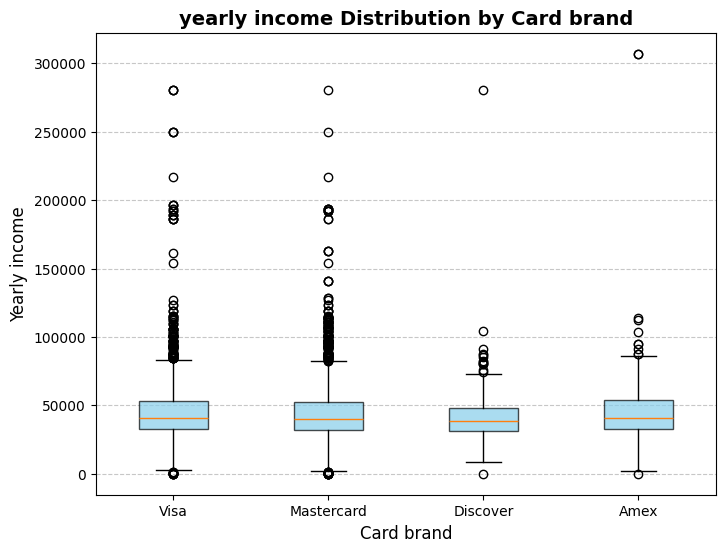

In [30]:
# Group data by card type
card_types = df_merged["card_brand"].unique().tolist()
credit_limit_data = [df_merged[df_merged["card_brand"] == ct]["yearly_income"].tolist() for ct in card_types]

# Plot the box plot
plt.figure(figsize=(8, 6))
plt.boxplot(credit_limit_data, tick_labels=card_types, patch_artist=True, boxprops=dict(facecolor="skyblue", alpha=0.7))

# Add labels and title
plt.xlabel("Card brand", fontsize=12)
plt.ylabel("Yearly income", fontsize=12)
plt.title("yearly income Distribution by Card brand", fontsize=14, fontweight="bold")

# Show the plot
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


# **regression analysis**

In [31]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [32]:
# Step 1: Perform Regression Analysis
# Defining the regression formula: Dependent variable 'credit_limit' ~ Independent variable 'yearly_income'
model = smf.ols(formula='credit_limit ~ yearly_income', data=df_merged).fit()
# Step 2: Null and Alternative Hypotheses for the slope (yearly_income):
# H0: β1 = 0 (No relationship between yearly income and credit limit)
# Ha: β1 ≠ 0 (There is a relationship between yearly income and credit limit)
print(f"Null Hypothesis: H0: β1 = 0\n")
print(f"Alternative Hypothesis: Ha: β1 ≠ 0\n")

# Step 3: Get t-statistics and p-values for coefficients
t_values = model.tvalues
p_values = model.pvalues

# Output t-statistics and p-values for coefficients
print(f"T-statistics: \n{t_values}\n")
print(f"P-values: \n{p_values}\n")

# Step 4: Calculate and interpret the p-value for the slope coefficient (yearly_income)
# Check if p-value for 'yearly_income' is less than 0.05 (significant)
if p_values['yearly_income'] < 0.05:
    print("Decision: Reject the null hypothesis. There is significant evidence that yearly income affects credit limit.\n")
else:
    print("Decision: Fail to reject the null hypothesis. There is no significant evidence that yearly income affects credit limit.\n")

# Step 5: Confidence Interval for the slope (β1)
# 95% Confidence Interval for 'yearly_income' coefficient
conf_int_95 = model.conf_int(alpha=0.05)  # 95% confidence interval
print(f"95% Confidence Interval for yearly_income coefficient: \n{conf_int_95.loc['yearly_income']}\n")

# Interpretation of Confidence Interval
low, high = conf_int_95.loc['yearly_income']
print(f"Interpretation: With 95% confidence, for each additional unit increase in yearly income, "
        f"there is an associated increase in the credit limit between {low:.2f} and {high:.2f}.\n")

# Step 6: Optional - Calculate a 90% Confidence Interval for the slope (β1)
conf_int_90 = model.conf_int(alpha=0.10)  # 90% confidence interval
print(f"90% Confidence Interval for yearly_income coefficient: \n{conf_int_90.loc['yearly_income']}\n")

# Interpretation of Confidence Interval
low_90, high_90 = conf_int_90.loc['yearly_income']
print(f"Interpretation: With 90% confidence, for each additional unit increase in yearly income, "
        f"there is an associated increase in the credit limit between {low_90:.2f} and {high_90:.2f}.\n")

# Step 7: Calculate Residuals and the Mean Squared Error (MSE)
residuals = model.resid
mse = np.mean(residuals**2)
print(f"Mean Squared Error (MSE): {mse:.4f}\n")

# Step 8: Calculate t-statistic manually (for educational purpose)
# b1: estimated coefficient (slope for 'yearly_income'), SEb1: standard error of b1
b1 = model.params['yearly_income']
SEb1 = model.bse['yearly_income']

# Test statistic for b1 (slope)
t_stat = b1 / SEb1
print(f"Calculated t-statistic for yearly_income: {t_stat:.4f}\n")

# Step 9: Additional Statistics (e.g., R-squared)
r_squared = model.rsquared
print(f"R-squared: {r_squared:.4f}\n")

# Step 10: F-statistic for overall regression model
f_statistic = model.fvalue
print(f"F-statistic: {f_statistic:.4f}\n")

# Step 11: Decision based on overall F-test p-value
f_pvalue = model.f_pvalue
if f_pvalue < 0.05:
    print("Decision: Reject the null hypothesis for the overall model. There is a significant relationship between yearly income and credit limit.\n")
else:
    print("Decision: Fail to reject the null hypothesis for the overall model. There is no significant relationship between yearly income and credit limit.\n")

# Step 12: Conclusion
print("Conclusion: Based on the regression results, there is significant evidence of a relationship between yearly income and credit limit.\n")


Null Hypothesis: H0: β1 = 0

Alternative Hypothesis: Ha: β1 ≠ 0

T-statistics: 
Intercept         5.543009
yearly_income    51.337012
dtype: float64

P-values: 
Intercept        3.096819e-08
yearly_income    0.000000e+00
dtype: float64

Decision: Reject the null hypothesis. There is significant evidence that yearly income affects credit limit.

95% Confidence Interval for yearly_income coefficient: 
0    0.271564
1    0.293127
Name: yearly_income, dtype: float64

Interpretation: With 95% confidence, for each additional unit increase in yearly income, there is an associated increase in the credit limit between 0.27 and 0.29.

90% Confidence Interval for yearly_income coefficient: 
0    0.273297
1    0.291393
Name: yearly_income, dtype: float64

Interpretation: With 90% confidence, for each additional unit increase in yearly income, there is an associated increase in the credit limit between 0.27 and 0.29.

Mean Squared Error (MSE): 100999703.9848

Calculated t-statistic for yearly_incom